# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [17]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [18]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [19]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [20]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [21]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [22]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

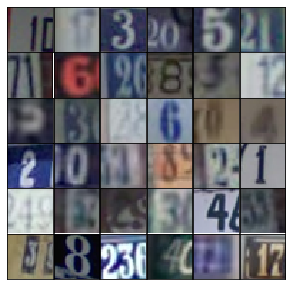

In [23]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

## Network Inputs

Here, just creating some placeholders like normal.

In [24]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [25]:
def conv_transpose_layer(prev_layer, filter, kernel_size, strides, is_training, alpha):
    x = tf.layers.conv2d_transpose(prev_layer, filter, kernel_size, strides, 'same')
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.maximum(x, alpha*x)
    return x

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(x1, alpha*x1)
        # 4x4x512 now

        x2 = conv_transpose_layer(x1, 256, 5, 2, training, alpha)
        # 8x8x256 now
        
        x3 = conv_transpose_layer(x2, 128, 5, 2, training, alpha)
        # 16x16x128 now
               
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, 2, 'same')
        # 32x32x3 now

        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [26]:
def conv_layer(prev_layer, filters, is_training, alpha, batch_norm=True):
    conv_layer = tf.layers.conv2d(prev_layer, filters, 5, 2, 'same', use_bias=False, activation=None)
    if batch_norm:
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_training)
    conv_layer = tf.maximum(conv_layer, alpha*conv_layer)
    return conv_layer

def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = conv_layer(x, 64, True, alpha, False)
        # 16x16x64

        x2 = conv_layer(x1, 128, True, alpha, True)
        # 8x8x128

        x3 = conv_layer(x2, 256, True, alpha, True)
        # 4x4x256

        flat = tf.reshape(x3, (-1, 4*4*256))

        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [36]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    #d_loss_real = tf.reduce_mean(
        #tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #d_loss_fake = tf.reduce_mean(
        #tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss_real=tf.reduce_mean(tf.scalar_mul(-1,d_logits_real))
    d_loss_fake=tf.reduce_mean(d_logits_fake)
    
    
    #g_loss = tf.reduce_mean(
        #tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    g_loss=tf.reduce_mean(tf.scalar_mul(-1,d_logits_fake))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [37]:
CLIP=[-0.01,0.01]
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #Change to RMSpropOptimizer
        d_train_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        #Then do weight cliping
        clip_d_op=[var.assign(tf.clip_by_value(var,CLIP[0],CLIP[1])) for var in d_vars]
    return d_train_opt, g_train_opt,clip_d_op

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [38]:
"""
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt, self.clip_d_op = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
"""
#original     
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt, self.clip_d_op = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [39]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [40]:
########################
#在train裡面要加入clip_operation
#################
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                #d 跑25次g跑一次
                for _ in range(25):
                    _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                ###############################
                #clip operation 放到這邊
                ###############################
                    sess.run(net.clip_d_op, feed_dict={net.input_real: x, net.input_z: batch_z})
                #跑玩d 25次之後跑G
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [41]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: -0.0000... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0001... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0001... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0001... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0002... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0002... Generator Loss: -0.0000
Epoch 1/25... Discriminator Loss: -0.0002... Generator Loss: 0.0000
Epoch 1/25... Discriminator Loss: -0.0002... Generator Loss: 0.0001
Epoch 1/25... Discriminator Loss: -0.0003... Generator Loss: 0.0001
Epoch 1/25... Discriminator Loss: -0.0003... Generator Loss: 0.0002


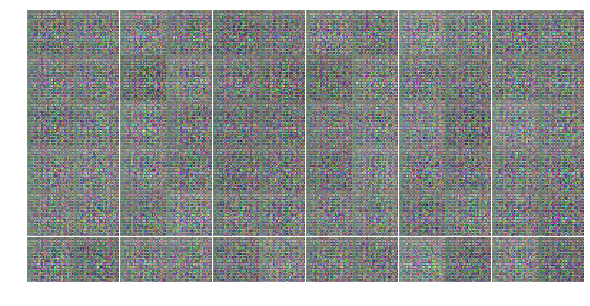

Epoch 1/25... Discriminator Loss: -0.0004... Generator Loss: 0.0003
Epoch 1/25... Discriminator Loss: -0.0004... Generator Loss: 0.0003
Epoch 1/25... Discriminator Loss: -0.0005... Generator Loss: 0.0004
Epoch 1/25... Discriminator Loss: -0.0006... Generator Loss: 0.0005
Epoch 1/25... Discriminator Loss: -0.0007... Generator Loss: 0.0008
Epoch 1/25... Discriminator Loss: -0.0010... Generator Loss: 0.0008
Epoch 1/25... Discriminator Loss: -0.0011... Generator Loss: 0.0008
Epoch 1/25... Discriminator Loss: -0.0029... Generator Loss: 0.0011
Epoch 1/25... Discriminator Loss: -0.0083... Generator Loss: 0.0001
Epoch 1/25... Discriminator Loss: -0.0107... Generator Loss: -0.0028


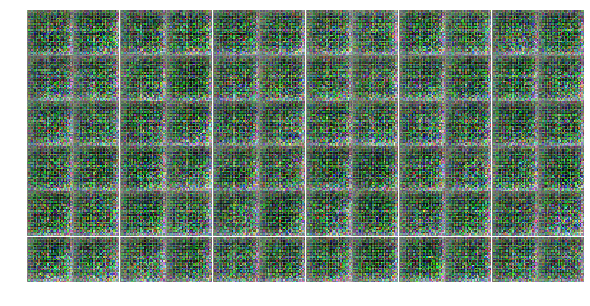

Epoch 1/25... Discriminator Loss: -0.0003... Generator Loss: -0.0042
Epoch 1/25... Discriminator Loss: 0.0001... Generator Loss: -0.0032
Epoch 1/25... Discriminator Loss: 0.0024... Generator Loss: -0.0056
Epoch 1/25... Discriminator Loss: -0.0005... Generator Loss: -0.0064
Epoch 1/25... Discriminator Loss: -0.0004... Generator Loss: -0.0034
Epoch 1/25... Discriminator Loss: -0.0014... Generator Loss: -0.0043
Epoch 1/25... Discriminator Loss: -0.0039... Generator Loss: 0.0003
Epoch 1/25... Discriminator Loss: -0.0065... Generator Loss: 0.0030
Epoch 1/25... Discriminator Loss: -0.0035... Generator Loss: -0.0029
Epoch 1/25... Discriminator Loss: -0.0055... Generator Loss: 0.0035


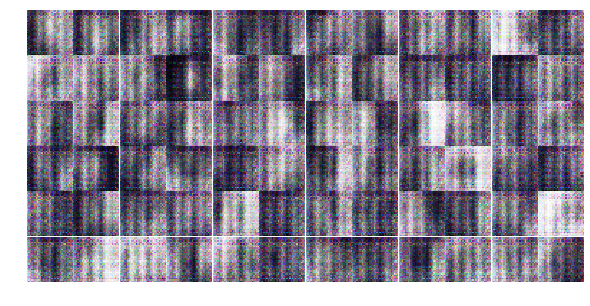

Epoch 1/25... Discriminator Loss: -0.0076... Generator Loss: 0.0023
Epoch 1/25... Discriminator Loss: -0.0068... Generator Loss: 0.0096
Epoch 1/25... Discriminator Loss: -0.0119... Generator Loss: 0.0070
Epoch 1/25... Discriminator Loss: -0.0092... Generator Loss: 0.0084
Epoch 1/25... Discriminator Loss: -0.0154... Generator Loss: 0.0142
Epoch 1/25... Discriminator Loss: -0.0136... Generator Loss: 0.0101
Epoch 1/25... Discriminator Loss: -0.0170... Generator Loss: 0.0092
Epoch 1/25... Discriminator Loss: -0.0221... Generator Loss: 0.0204
Epoch 1/25... Discriminator Loss: -0.0144... Generator Loss: 0.0110
Epoch 1/25... Discriminator Loss: -0.0223... Generator Loss: 0.0173


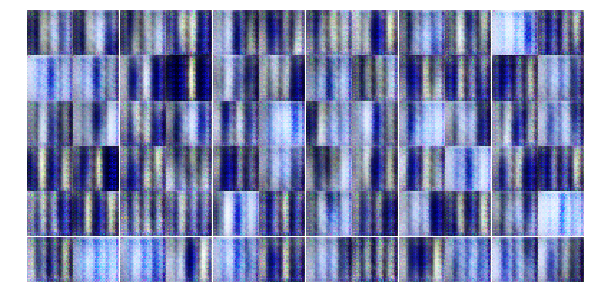

Epoch 1/25... Discriminator Loss: -0.0195... Generator Loss: 0.0110
Epoch 1/25... Discriminator Loss: -0.0134... Generator Loss: 0.0171
Epoch 1/25... Discriminator Loss: -0.0215... Generator Loss: 0.0237
Epoch 1/25... Discriminator Loss: -0.0251... Generator Loss: 0.0097
Epoch 1/25... Discriminator Loss: -0.0217... Generator Loss: 0.0107
Epoch 1/25... Discriminator Loss: -0.0246... Generator Loss: 0.0025
Epoch 1/25... Discriminator Loss: -0.0188... Generator Loss: 0.0006
Epoch 1/25... Discriminator Loss: -0.0227... Generator Loss: 0.0103
Epoch 1/25... Discriminator Loss: -0.0226... Generator Loss: 0.0110
Epoch 1/25... Discriminator Loss: -0.0200... Generator Loss: -0.0030


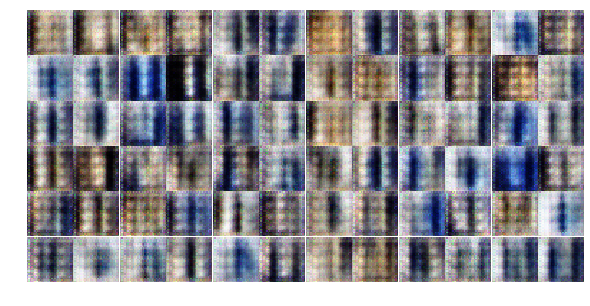

Epoch 1/25... Discriminator Loss: -0.0102... Generator Loss: -0.0163
Epoch 1/25... Discriminator Loss: -0.0169... Generator Loss: 0.0029
Epoch 1/25... Discriminator Loss: -0.0098... Generator Loss: 0.0015
Epoch 1/25... Discriminator Loss: -0.0210... Generator Loss: -0.0086
Epoch 1/25... Discriminator Loss: -0.0188... Generator Loss: 0.0011
Epoch 1/25... Discriminator Loss: -0.0240... Generator Loss: -0.0008
Epoch 1/25... Discriminator Loss: -0.0086... Generator Loss: -0.0049
Epoch 2/25... Discriminator Loss: -0.0240... Generator Loss: 0.0086
Epoch 2/25... Discriminator Loss: -0.0204... Generator Loss: -0.0040
Epoch 2/25... Discriminator Loss: -0.0230... Generator Loss: -0.0119


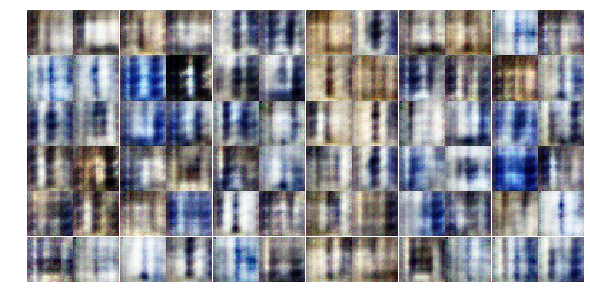

Epoch 2/25... Discriminator Loss: -0.0117... Generator Loss: -0.0112
Epoch 2/25... Discriminator Loss: -0.0157... Generator Loss: -0.0142
Epoch 2/25... Discriminator Loss: -0.0119... Generator Loss: -0.0016
Epoch 2/25... Discriminator Loss: -0.0177... Generator Loss: -0.0183
Epoch 2/25... Discriminator Loss: -0.0096... Generator Loss: -0.0120
Epoch 2/25... Discriminator Loss: -0.0127... Generator Loss: -0.0047
Epoch 2/25... Discriminator Loss: -0.0118... Generator Loss: -0.0190
Epoch 2/25... Discriminator Loss: -0.0089... Generator Loss: -0.0132
Epoch 2/25... Discriminator Loss: -0.0071... Generator Loss: -0.0054
Epoch 2/25... Discriminator Loss: -0.0167... Generator Loss: -0.0214


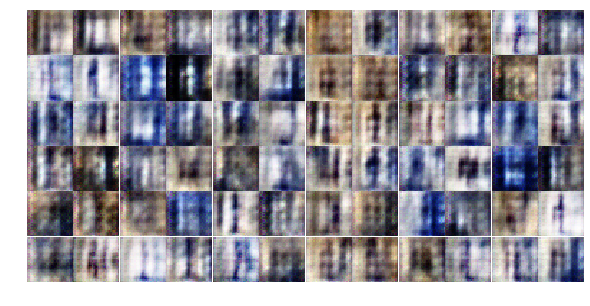

Epoch 2/25... Discriminator Loss: -0.0138... Generator Loss: -0.0181
Epoch 2/25... Discriminator Loss: -0.0078... Generator Loss: -0.0317
Epoch 2/25... Discriminator Loss: -0.0112... Generator Loss: 0.0004
Epoch 2/25... Discriminator Loss: -0.0083... Generator Loss: -0.0389
Epoch 2/25... Discriminator Loss: -0.0098... Generator Loss: -0.0199
Epoch 2/25... Discriminator Loss: -0.0085... Generator Loss: -0.0227
Epoch 2/25... Discriminator Loss: -0.0082... Generator Loss: -0.0246
Epoch 2/25... Discriminator Loss: -0.0096... Generator Loss: -0.0306
Epoch 2/25... Discriminator Loss: -0.0072... Generator Loss: -0.0269
Epoch 2/25... Discriminator Loss: -0.0114... Generator Loss: 0.0010


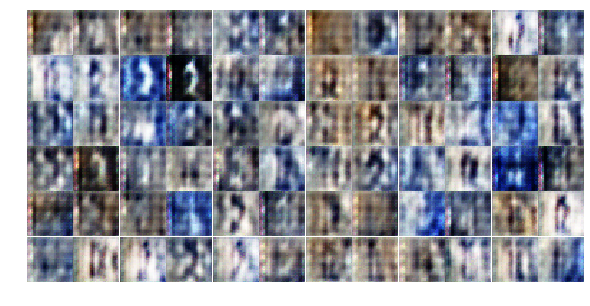

Epoch 2/25... Discriminator Loss: -0.0088... Generator Loss: -0.0127
Epoch 2/25... Discriminator Loss: -0.0068... Generator Loss: 0.0006
Epoch 2/25... Discriminator Loss: -0.0172... Generator Loss: 0.0022
Epoch 2/25... Discriminator Loss: -0.0023... Generator Loss: -0.0127
Epoch 2/25... Discriminator Loss: -0.0093... Generator Loss: -0.0079
Epoch 2/25... Discriminator Loss: -0.0117... Generator Loss: -0.0261
Epoch 2/25... Discriminator Loss: -0.0117... Generator Loss: -0.0215
Epoch 2/25... Discriminator Loss: -0.0038... Generator Loss: -0.0256
Epoch 2/25... Discriminator Loss: -0.0115... Generator Loss: -0.0112
Epoch 2/25... Discriminator Loss: -0.0063... Generator Loss: -0.0197


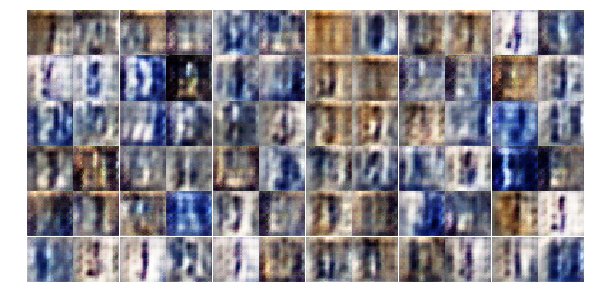

Epoch 2/25... Discriminator Loss: -0.0056... Generator Loss: -0.0185
Epoch 2/25... Discriminator Loss: -0.0007... Generator Loss: -0.0081
Epoch 2/25... Discriminator Loss: -0.0055... Generator Loss: 0.0023
Epoch 2/25... Discriminator Loss: -0.0167... Generator Loss: -0.0053
Epoch 2/25... Discriminator Loss: -0.0077... Generator Loss: -0.0033
Epoch 2/25... Discriminator Loss: -0.0031... Generator Loss: -0.0237
Epoch 2/25... Discriminator Loss: -0.0065... Generator Loss: -0.0179
Epoch 2/25... Discriminator Loss: -0.0106... Generator Loss: 0.0121
Epoch 2/25... Discriminator Loss: -0.0067... Generator Loss: 0.0011
Epoch 2/25... Discriminator Loss: -0.0029... Generator Loss: -0.0127


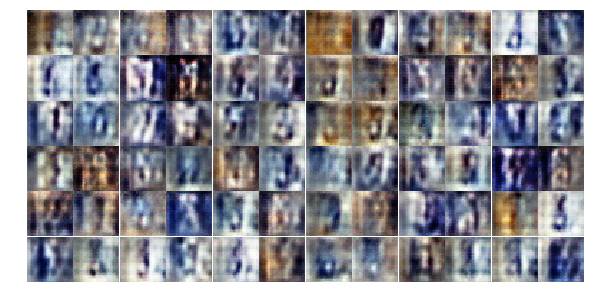

Epoch 2/25... Discriminator Loss: -0.0107... Generator Loss: -0.0181
Epoch 2/25... Discriminator Loss: -0.0110... Generator Loss: 0.0059
Epoch 2/25... Discriminator Loss: -0.0067... Generator Loss: -0.0172
Epoch 2/25... Discriminator Loss: -0.0099... Generator Loss: -0.0006
Epoch 2/25... Discriminator Loss: 0.0020... Generator Loss: -0.0282
Epoch 2/25... Discriminator Loss: -0.0026... Generator Loss: -0.0109
Epoch 2/25... Discriminator Loss: -0.0102... Generator Loss: -0.0205
Epoch 2/25... Discriminator Loss: -0.0085... Generator Loss: -0.0222
Epoch 2/25... Discriminator Loss: -0.0152... Generator Loss: -0.0278
Epoch 2/25... Discriminator Loss: -0.0087... Generator Loss: 0.0037


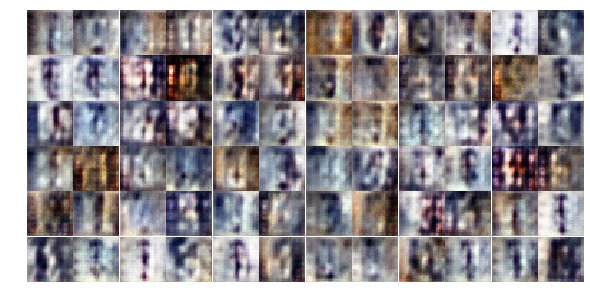

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 0.0031
Epoch 2/25... Discriminator Loss: -0.0060... Generator Loss: -0.0093
Epoch 2/25... Discriminator Loss: 0.0009... Generator Loss: -0.0158
Epoch 2/25... Discriminator Loss: -0.0095... Generator Loss: -0.0082
Epoch 3/25... Discriminator Loss: -0.0138... Generator Loss: -0.0152
Epoch 3/25... Discriminator Loss: -0.0016... Generator Loss: 0.0021
Epoch 3/25... Discriminator Loss: -0.0054... Generator Loss: 0.0064
Epoch 3/25... Discriminator Loss: -0.0161... Generator Loss: 0.0099
Epoch 3/25... Discriminator Loss: -0.0093... Generator Loss: 0.0168
Epoch 3/25... Discriminator Loss: -0.0069... Generator Loss: -0.0137


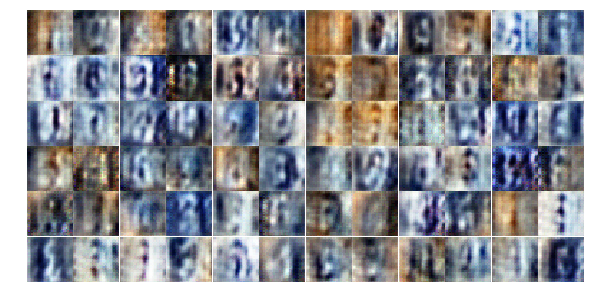

Epoch 3/25... Discriminator Loss: 0.0002... Generator Loss: 0.0008
Epoch 3/25... Discriminator Loss: -0.0065... Generator Loss: -0.0155
Epoch 3/25... Discriminator Loss: -0.0057... Generator Loss: -0.0102
Epoch 3/25... Discriminator Loss: -0.0023... Generator Loss: 0.0073
Epoch 3/25... Discriminator Loss: -0.0077... Generator Loss: -0.0083
Epoch 3/25... Discriminator Loss: -0.0066... Generator Loss: -0.0018
Epoch 3/25... Discriminator Loss: -0.0031... Generator Loss: -0.0083
Epoch 3/25... Discriminator Loss: -0.0053... Generator Loss: -0.0001
Epoch 3/25... Discriminator Loss: -0.0107... Generator Loss: -0.0219
Epoch 3/25... Discriminator Loss: -0.0017... Generator Loss: -0.0055


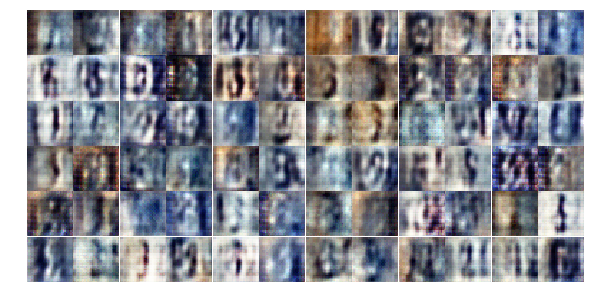

Epoch 3/25... Discriminator Loss: -0.0011... Generator Loss: 0.0059
Epoch 3/25... Discriminator Loss: -0.0023... Generator Loss: -0.0079
Epoch 3/25... Discriminator Loss: -0.0084... Generator Loss: -0.0198
Epoch 3/25... Discriminator Loss: -0.0039... Generator Loss: 0.0022
Epoch 3/25... Discriminator Loss: -0.0006... Generator Loss: 0.0080
Epoch 3/25... Discriminator Loss: -0.0064... Generator Loss: 0.0039
Epoch 3/25... Discriminator Loss: -0.0107... Generator Loss: -0.0105
Epoch 3/25... Discriminator Loss: -0.0065... Generator Loss: -0.0015
Epoch 3/25... Discriminator Loss: -0.0065... Generator Loss: -0.0171
Epoch 3/25... Discriminator Loss: -0.0011... Generator Loss: 0.0082


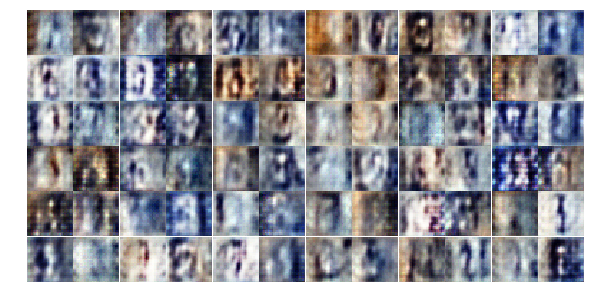

Epoch 3/25... Discriminator Loss: -0.0016... Generator Loss: -0.0114
Epoch 3/25... Discriminator Loss: -0.0042... Generator Loss: -0.0081
Epoch 3/25... Discriminator Loss: 0.0071... Generator Loss: 0.0108
Epoch 3/25... Discriminator Loss: -0.0115... Generator Loss: 0.0002
Epoch 3/25... Discriminator Loss: 0.0047... Generator Loss: 0.0045
Epoch 3/25... Discriminator Loss: -0.0009... Generator Loss: 0.0171
Epoch 3/25... Discriminator Loss: 0.0002... Generator Loss: -0.0101
Epoch 3/25... Discriminator Loss: -0.0025... Generator Loss: 0.0089
Epoch 3/25... Discriminator Loss: -0.0038... Generator Loss: 0.0128
Epoch 3/25... Discriminator Loss: -0.0016... Generator Loss: -0.0288


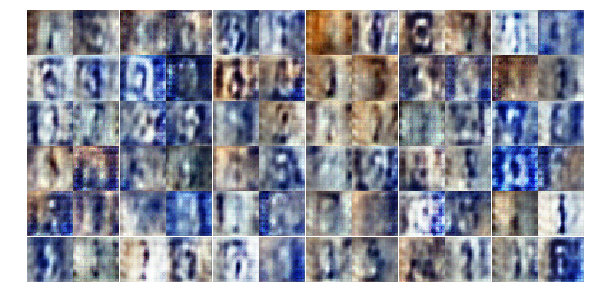

Epoch 3/25... Discriminator Loss: -0.0019... Generator Loss: 0.0031
Epoch 3/25... Discriminator Loss: 0.0009... Generator Loss: -0.0343
Epoch 3/25... Discriminator Loss: -0.0047... Generator Loss: 0.0100
Epoch 3/25... Discriminator Loss: -0.0105... Generator Loss: -0.0059
Epoch 3/25... Discriminator Loss: -0.0046... Generator Loss: -0.0042
Epoch 3/25... Discriminator Loss: -0.0058... Generator Loss: -0.0087
Epoch 3/25... Discriminator Loss: -0.0026... Generator Loss: -0.0100
Epoch 3/25... Discriminator Loss: -0.0052... Generator Loss: -0.0076
Epoch 3/25... Discriminator Loss: 0.0006... Generator Loss: -0.0155
Epoch 3/25... Discriminator Loss: -0.0016... Generator Loss: -0.0037


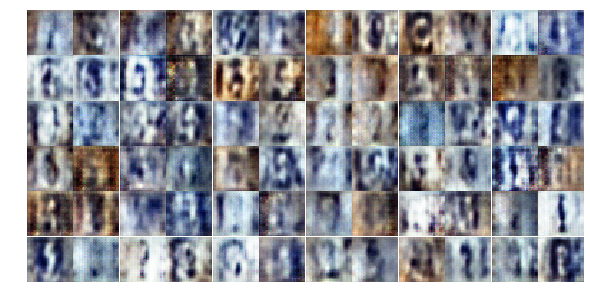

Epoch 3/25... Discriminator Loss: -0.0008... Generator Loss: -0.0040
Epoch 3/25... Discriminator Loss: -0.0009... Generator Loss: -0.0014
Epoch 3/25... Discriminator Loss: -0.0001... Generator Loss: 0.0111
Epoch 3/25... Discriminator Loss: -0.0060... Generator Loss: 0.0140
Epoch 3/25... Discriminator Loss: -0.0059... Generator Loss: -0.0024
Epoch 3/25... Discriminator Loss: 0.0035... Generator Loss: -0.0104
Epoch 3/25... Discriminator Loss: -0.0017... Generator Loss: 0.0030
Epoch 3/25... Discriminator Loss: 0.0033... Generator Loss: -0.0210
Epoch 3/25... Discriminator Loss: -0.0025... Generator Loss: -0.0136
Epoch 3/25... Discriminator Loss: -0.0015... Generator Loss: -0.0076


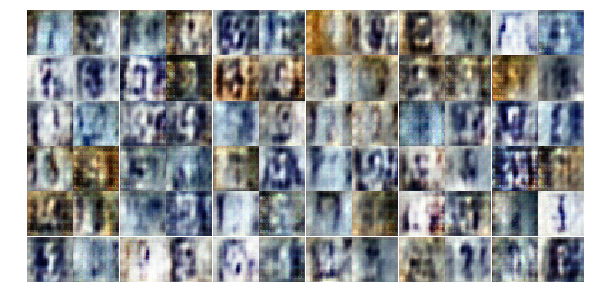

Epoch 3/25... Discriminator Loss: -0.0017... Generator Loss: -0.0078
Epoch 4/25... Discriminator Loss: 0.0027... Generator Loss: 0.0033
Epoch 4/25... Discriminator Loss: -0.0001... Generator Loss: -0.0059
Epoch 4/25... Discriminator Loss: -0.0065... Generator Loss: -0.0176
Epoch 4/25... Discriminator Loss: -0.0048... Generator Loss: -0.0139
Epoch 4/25... Discriminator Loss: -0.0007... Generator Loss: -0.0124
Epoch 4/25... Discriminator Loss: -0.0035... Generator Loss: -0.0089
Epoch 4/25... Discriminator Loss: -0.0055... Generator Loss: 0.0119
Epoch 4/25... Discriminator Loss: -0.0140... Generator Loss: -0.0174
Epoch 4/25... Discriminator Loss: 0.0006... Generator Loss: 0.0003


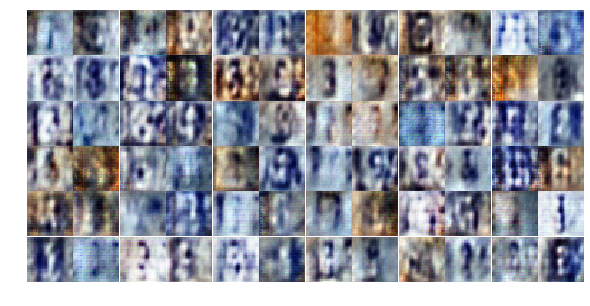

Epoch 4/25... Discriminator Loss: -0.0034... Generator Loss: -0.0142
Epoch 4/25... Discriminator Loss: -0.0022... Generator Loss: 0.0031
Epoch 4/25... Discriminator Loss: 0.0016... Generator Loss: -0.0161
Epoch 4/25... Discriminator Loss: -0.0037... Generator Loss: -0.0049
Epoch 4/25... Discriminator Loss: -0.0024... Generator Loss: -0.0121
Epoch 4/25... Discriminator Loss: 0.0007... Generator Loss: -0.0071
Epoch 4/25... Discriminator Loss: -0.0010... Generator Loss: 0.0117
Epoch 4/25... Discriminator Loss: -0.0029... Generator Loss: 0.0011
Epoch 4/25... Discriminator Loss: -0.0037... Generator Loss: 0.0015
Epoch 4/25... Discriminator Loss: -0.0000... Generator Loss: 0.0000


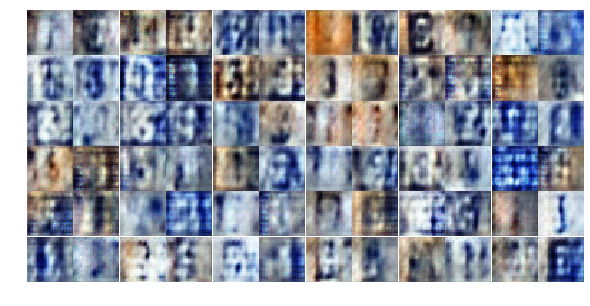

Epoch 4/25... Discriminator Loss: -0.0033... Generator Loss: 0.0062
Epoch 4/25... Discriminator Loss: -0.0023... Generator Loss: -0.0151
Epoch 4/25... Discriminator Loss: -0.0028... Generator Loss: -0.0041
Epoch 4/25... Discriminator Loss: -0.0024... Generator Loss: -0.0005
Epoch 4/25... Discriminator Loss: -0.0041... Generator Loss: -0.0093
Epoch 4/25... Discriminator Loss: -0.0025... Generator Loss: 0.0094
Epoch 4/25... Discriminator Loss: -0.0077... Generator Loss: -0.0135
Epoch 4/25... Discriminator Loss: -0.0055... Generator Loss: -0.0154
Epoch 4/25... Discriminator Loss: -0.0024... Generator Loss: 0.0000
Epoch 4/25... Discriminator Loss: -0.0056... Generator Loss: -0.0122


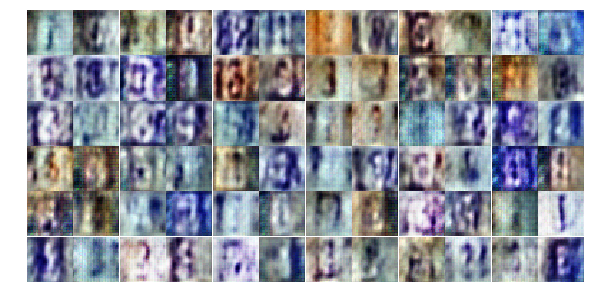

Epoch 4/25... Discriminator Loss: -0.0038... Generator Loss: -0.0081
Epoch 4/25... Discriminator Loss: -0.0022... Generator Loss: 0.0075
Epoch 4/25... Discriminator Loss: -0.0033... Generator Loss: -0.0104
Epoch 4/25... Discriminator Loss: 0.0010... Generator Loss: -0.0187
Epoch 4/25... Discriminator Loss: -0.0043... Generator Loss: -0.0032
Epoch 4/25... Discriminator Loss: -0.0018... Generator Loss: -0.0077
Epoch 4/25... Discriminator Loss: -0.0050... Generator Loss: -0.0126
Epoch 4/25... Discriminator Loss: 0.0004... Generator Loss: 0.0030
Epoch 4/25... Discriminator Loss: -0.0083... Generator Loss: -0.0151
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: -0.0021


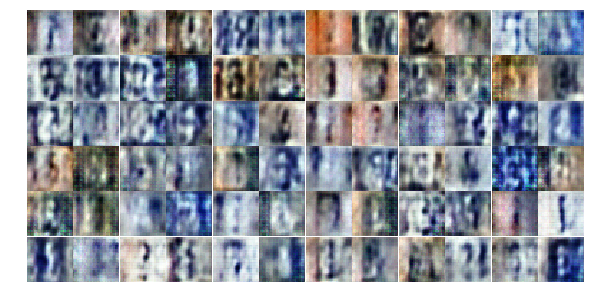

Epoch 4/25... Discriminator Loss: -0.0041... Generator Loss: -0.0061
Epoch 4/25... Discriminator Loss: -0.0049... Generator Loss: 0.0044
Epoch 4/25... Discriminator Loss: -0.0023... Generator Loss: -0.0091
Epoch 4/25... Discriminator Loss: -0.0029... Generator Loss: -0.0026
Epoch 4/25... Discriminator Loss: -0.0045... Generator Loss: 0.0062
Epoch 4/25... Discriminator Loss: -0.0032... Generator Loss: 0.0053
Epoch 4/25... Discriminator Loss: -0.0029... Generator Loss: -0.0126
Epoch 4/25... Discriminator Loss: 0.0049... Generator Loss: -0.0193
Epoch 4/25... Discriminator Loss: 0.0007... Generator Loss: -0.0034
Epoch 4/25... Discriminator Loss: 0.0008... Generator Loss: -0.0166


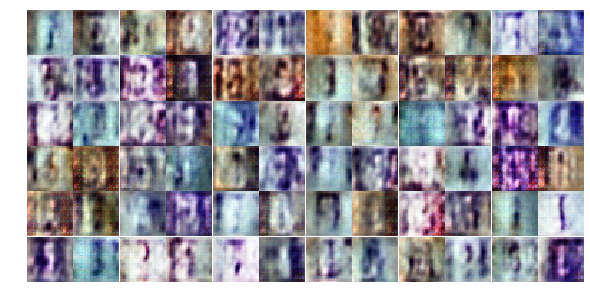

Epoch 4/25... Discriminator Loss: -0.0032... Generator Loss: -0.0089
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: -0.0129
Epoch 4/25... Discriminator Loss: -0.0058... Generator Loss: -0.0138
Epoch 4/25... Discriminator Loss: -0.0090... Generator Loss: 0.0102
Epoch 4/25... Discriminator Loss: -0.0014... Generator Loss: -0.0235
Epoch 4/25... Discriminator Loss: -0.0007... Generator Loss: 0.0001
Epoch 4/25... Discriminator Loss: -0.0054... Generator Loss: -0.0211
Epoch 4/25... Discriminator Loss: -0.0015... Generator Loss: 0.0069
Epoch 4/25... Discriminator Loss: -0.0049... Generator Loss: -0.0116
Epoch 5/25... Discriminator Loss: -0.0069... Generator Loss: -0.0162


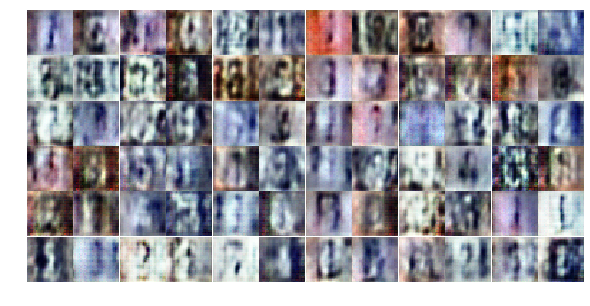

Epoch 5/25... Discriminator Loss: -0.0050... Generator Loss: -0.0081
Epoch 5/25... Discriminator Loss: -0.0065... Generator Loss: -0.0098
Epoch 5/25... Discriminator Loss: -0.0045... Generator Loss: 0.0026
Epoch 5/25... Discriminator Loss: -0.0089... Generator Loss: -0.0168
Epoch 5/25... Discriminator Loss: -0.0038... Generator Loss: -0.0184
Epoch 5/25... Discriminator Loss: -0.0039... Generator Loss: -0.0084
Epoch 5/25... Discriminator Loss: -0.0001... Generator Loss: -0.0086
Epoch 5/25... Discriminator Loss: -0.0016... Generator Loss: -0.0163
Epoch 5/25... Discriminator Loss: -0.0046... Generator Loss: -0.0129
Epoch 5/25... Discriminator Loss: -0.0020... Generator Loss: -0.0138


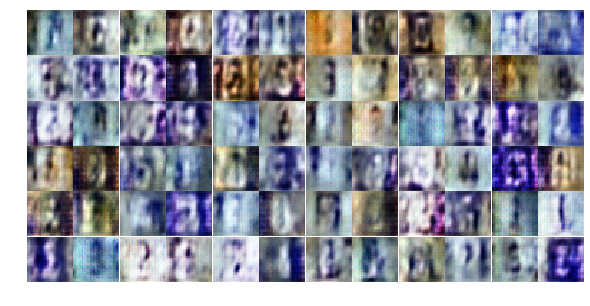

Epoch 5/25... Discriminator Loss: -0.0043... Generator Loss: -0.0051
Epoch 5/25... Discriminator Loss: -0.0048... Generator Loss: -0.0110
Epoch 5/25... Discriminator Loss: -0.0053... Generator Loss: -0.0157
Epoch 5/25... Discriminator Loss: -0.0019... Generator Loss: -0.0094
Epoch 5/25... Discriminator Loss: -0.0068... Generator Loss: 0.0090
Epoch 5/25... Discriminator Loss: -0.0025... Generator Loss: -0.0199
Epoch 5/25... Discriminator Loss: -0.0046... Generator Loss: -0.0095
Epoch 5/25... Discriminator Loss: -0.0037... Generator Loss: -0.0011
Epoch 5/25... Discriminator Loss: -0.0082... Generator Loss: -0.0124
Epoch 5/25... Discriminator Loss: -0.0023... Generator Loss: -0.0108


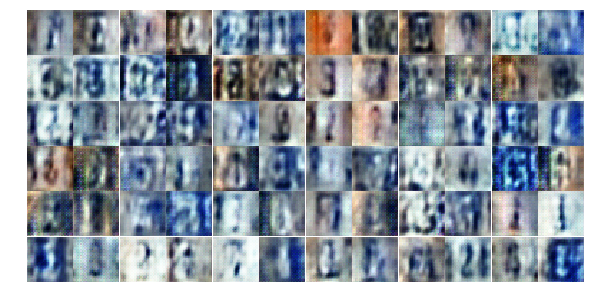

Epoch 5/25... Discriminator Loss: -0.0038... Generator Loss: -0.0031
Epoch 5/25... Discriminator Loss: -0.0064... Generator Loss: -0.0074
Epoch 5/25... Discriminator Loss: -0.0058... Generator Loss: -0.0018
Epoch 5/25... Discriminator Loss: -0.0062... Generator Loss: -0.0136
Epoch 5/25... Discriminator Loss: 0.0049... Generator Loss: -0.0021
Epoch 5/25... Discriminator Loss: -0.0080... Generator Loss: -0.0019
Epoch 5/25... Discriminator Loss: -0.0075... Generator Loss: -0.0060
Epoch 5/25... Discriminator Loss: -0.0040... Generator Loss: -0.0018


KeyboardInterrupt: 

In [42]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))